# 🧠 Sentiment Analysis Project - Group 4

## 📌 EDA Overview
This project focuses on analyzing and classifying sentiment from text data. Our goal is to explore the dataset deeply and apply NLP-based modeling.

## 📂 Folder Structure
- `data/` – Contains raw/cleaned datasets
- `notebooks/` – Individual team notebooks
- `scripts/` – Reusable functions and utilities
- `outputs/` – Graphs, word clouds, model predictions
- `reports/` – Final documentation & presentations

## 👥 Team Members
- **Smrithi** – Project setup and Analyzer
- **Kavimani** – Data collection,cleaning,and Textblob labeling
- **Manishankar** – Univariate/Bivariate analysis
- **Kiranvel** – NLP feature exploration
- **Vaishnavi** – EDA summary insights and ppt
- **Saran** – Task buliding deployment and Finalization
-**Abishek** - Final ppt and wordpad
-**Akshara** - Best Model Building
-**Sushinth VS** - Model building Evaluation (Accuracy,Roc AUC)

## 🛠 Tools & Tech
- Python, Pandas, Seaborn, NLTK, scikit-learn
- Google Colab, Google Drive

## ✅ Milestones
- [ ] Data loaded and cleaned
- [ ] EDA complete
- [ ] Feature engineering
- [ ] Model built
- [ ] Final insights + presentation

## 📎 Notes
Use consistent file naming (e.g., `eda_rocky.ipynb`). Store notebooks in the correct folders in Drive.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving amazon2.tsv to amazon2 (1).tsv


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


In [ ]:
# Load the data
df = pd.read_csv("/content/amazon2.tsv", sep='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
  # Drop rows with missing important values
  required_columns = ['rating', 'date', 'verified_reviews', 'variation']
  df.dropna(subset=required_columns, inplace=True)

In [ ]:
# Fix review text (lowercase handling)
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join([word.lower() if word.isupper() else word for word in x.split('\n')]))

In [ ]:
# Download nltk resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
# Text Preprocessing function
def preprocess_text(text, use_stemming=True, use_lemmatization=True):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    if use_stemming:
        words = [stemmer.stem(word) for word in words]
    if use_lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


In [ ]:
# Apply preprocessing
df['processed_text'] = df['verified_reviews'].apply(preprocess_text)

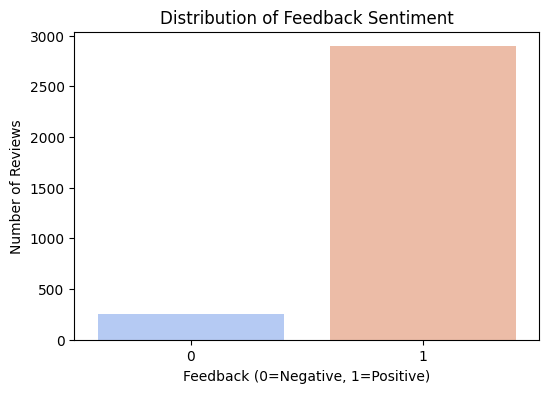

In [ ]:
# 1. Distribution of Feedback
plt.figure(figsize=(6,4))
sns.countplot(x='feedback', data=df, hue='feedback', palette='coolwarm', legend=False)
plt.title("Distribution of Feedback Sentiment")
plt.xlabel('Feedback (0=Negative, 1=Positive)')
plt.ylabel('Number of Reviews')
plt.show()

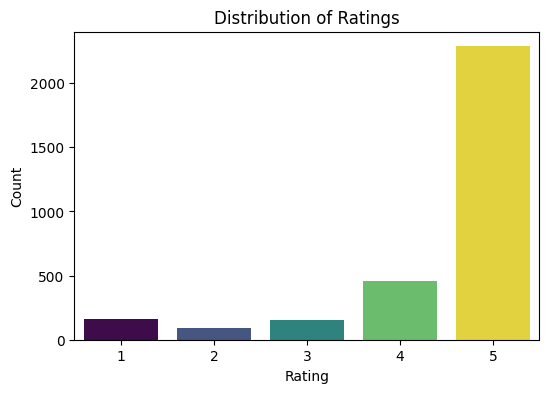

In [ ]:
# 2. Distribution of Ratings
plt.figure(figsize=(6,4))
sns.countplot(x='rating', hue = 'rating',data=df, palette='viridis',legend = False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

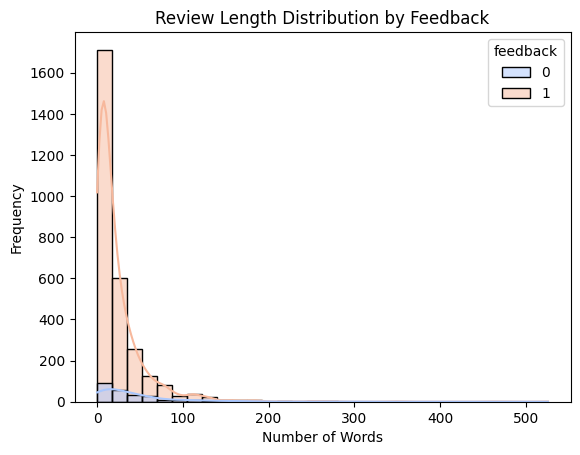

In [ ]:
# 3. Review Length Distribution
df['review_length'] = df['verified_reviews'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df, x='review_length', hue='feedback', kde=True, palette='coolwarm', bins=30)
plt.title('Review Length Distribution by Feedback')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

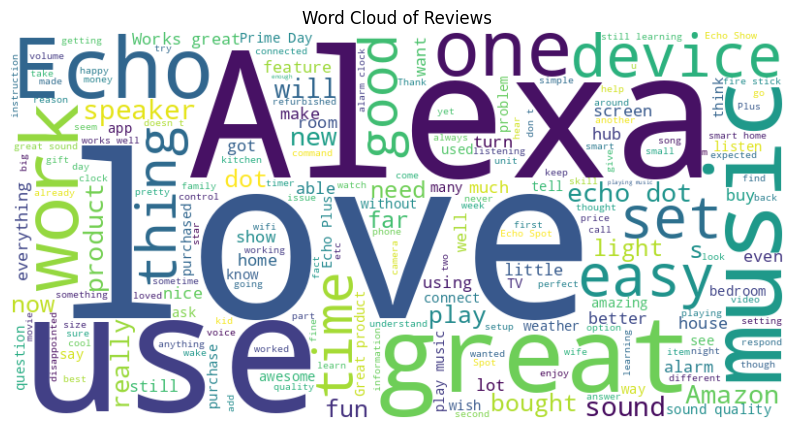

In [ ]:
# 4. WordCloud for All Reviews
all_reviews = ' '.join(df['verified_reviews'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Reviews")
plt.show()

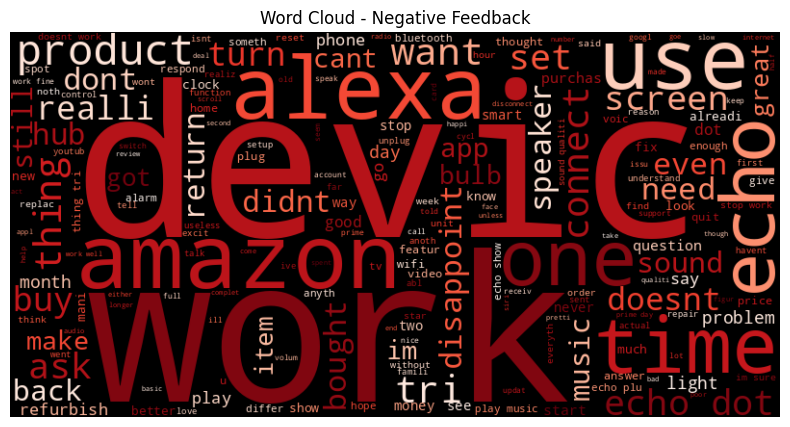

In [ ]:
# 5. WordCloud for Negative Reviews
negative_reviews = ' '.join(df[df['feedback']==0]['processed_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Feedback")
plt.show()

In [ ]:
# 6. Top 20 Words by Feedback
vectorizer = CountVectorizer(max_features=20, stop_words='english')
X_counts = vectorizer.fit_transform(df['processed_text'])
word_count = pd.DataFrame(X_counts.toarray(), columns=vectorizer.get_feature_names_out())
word_count['feedback'] = df['feedback']

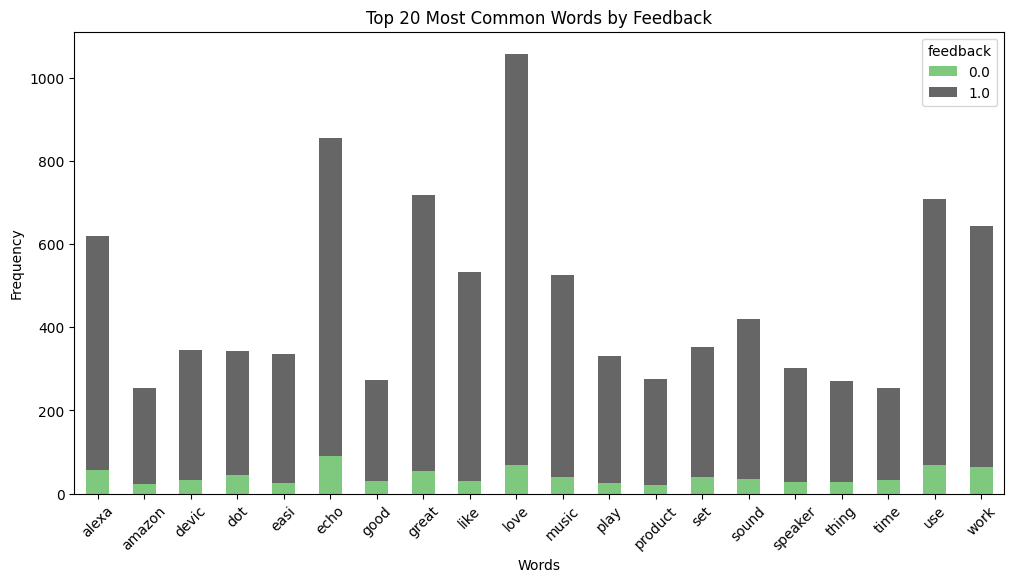

In [ ]:
word_grouped = word_count.groupby('feedback').sum()
word_grouped.T.plot(kind='bar', figsize=(12,6), stacked=True, colormap='Accent')
plt.title("Top 20 Most Common Words by Feedback")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 7. Top 10 Bigrams and Trigrams
def get_ngrams(text, n):
    tokens = text.split()
    return list(ngrams(tokens, n))

In [ ]:
df['bigrams'] = df['processed_text'].apply(lambda x: get_ngrams(x, 2))
df['trigrams'] = df['processed_text'].apply(lambda x: get_ngrams(x, 3))

In [ ]:
bigram_freq = Counter([bg for row in df['bigrams'] for bg in row])
trigram_freq = Counter([tg for row in df['trigrams'] for tg in row])

In [ ]:
top_bigrams = bigram_freq.most_common(10)
top_trigrams = trigram_freq.most_common(10)

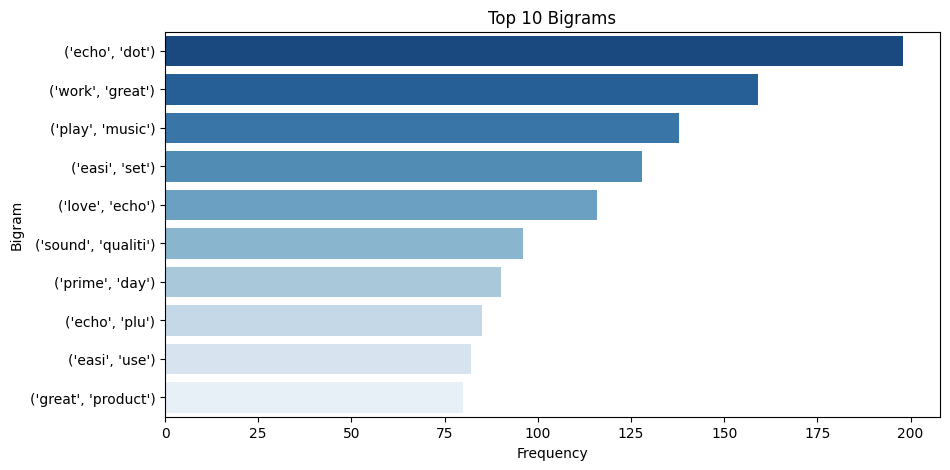

In [ ]:
# Plot Bigrams
plt.figure(figsize=(10,5))
labels, counts = zip(*top_bigrams)
sns.barplot(x=counts, y=[str(l) for l in labels], hue=[str(l) for l in labels], palette='Blues_r', legend=False)
plt.title("Top 10 Bigrams")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

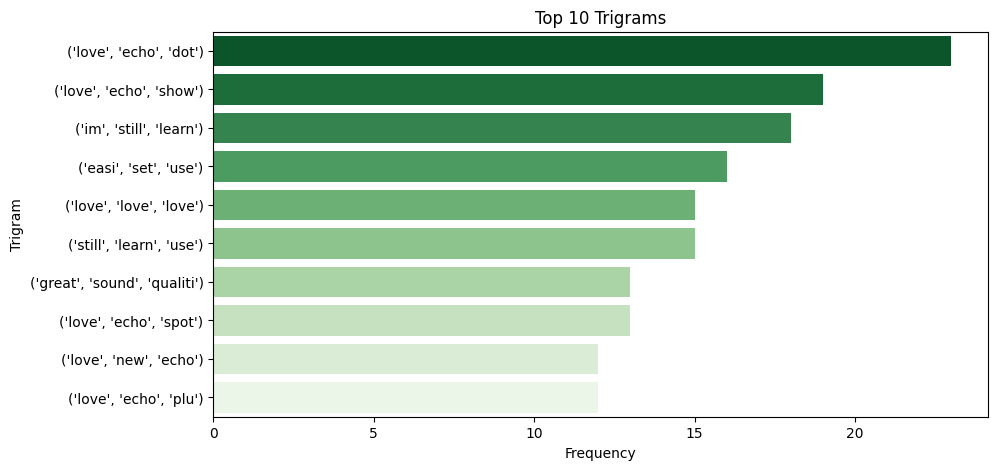

In [ ]:
# Plot Trigrams
plt.figure(figsize=(10,5))
labels, counts = zip(*top_trigrams)
sns.barplot(x=counts, y=[str(l) for l in labels],hue = [str(l) for l in labels],palette='Greens_r',legend =False)
plt.title("Top 10 Trigrams")
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.show()

In [ ]:
# 8. TF-IDF Visualization
tfidf = TfidfVectorizer(max_features=20, stop_words='english')
X_tfidf = tfidf.fit_transform(df['processed_text'])

In [ ]:
# Display TF-IDF matrix shape
print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (3149, 20)


In [ ]:
# Plot Top 10 TF-IDF for Positive Feedback
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df['feedback'] = df['feedback']
mean_tfidf = tfidf_df.groupby('feedback').mean().T

In [ ]:
top_pos = mean_tfidf.sort_values(by=1, ascending=False).head(10)

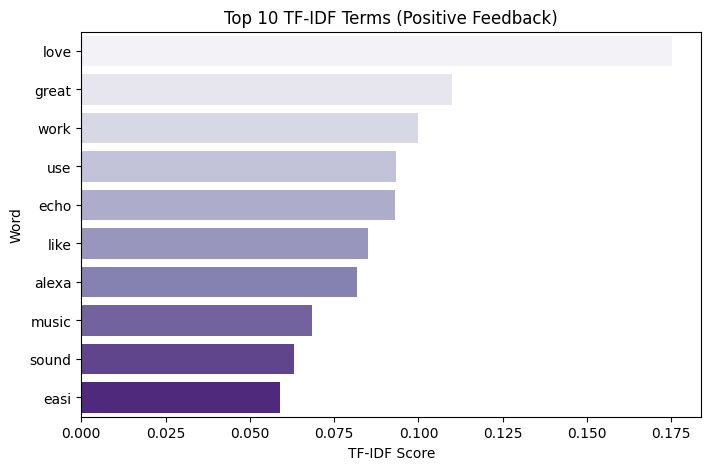

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=top_pos[1], y=top_pos.index, hue=top_pos.index, palette='Purples', legend=False)
plt.title("Top 10 TF-IDF Terms (Positive Feedback)")
plt.xlabel("TF-IDF Score")
plt.ylabel("Word")
plt.show()

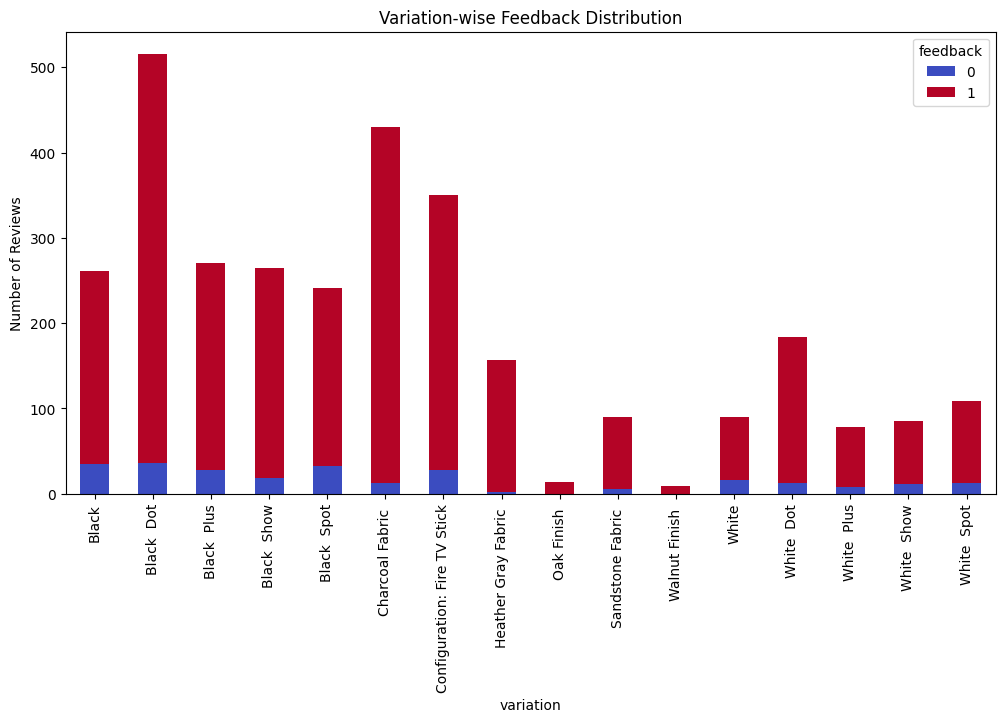

In [ ]:
# 9. Variation-wise Feedback Distribution
variation_feedback = df.groupby(['variation', 'feedback']).size().unstack().fillna(0)
variation_feedback.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title('Variation-wise Feedback Distribution')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 10. Correlation Heatmap
corr_df = tfidf_df.copy()
corr_df['review_length'] = df['review_length']
corr_matrix = corr_df.corr()


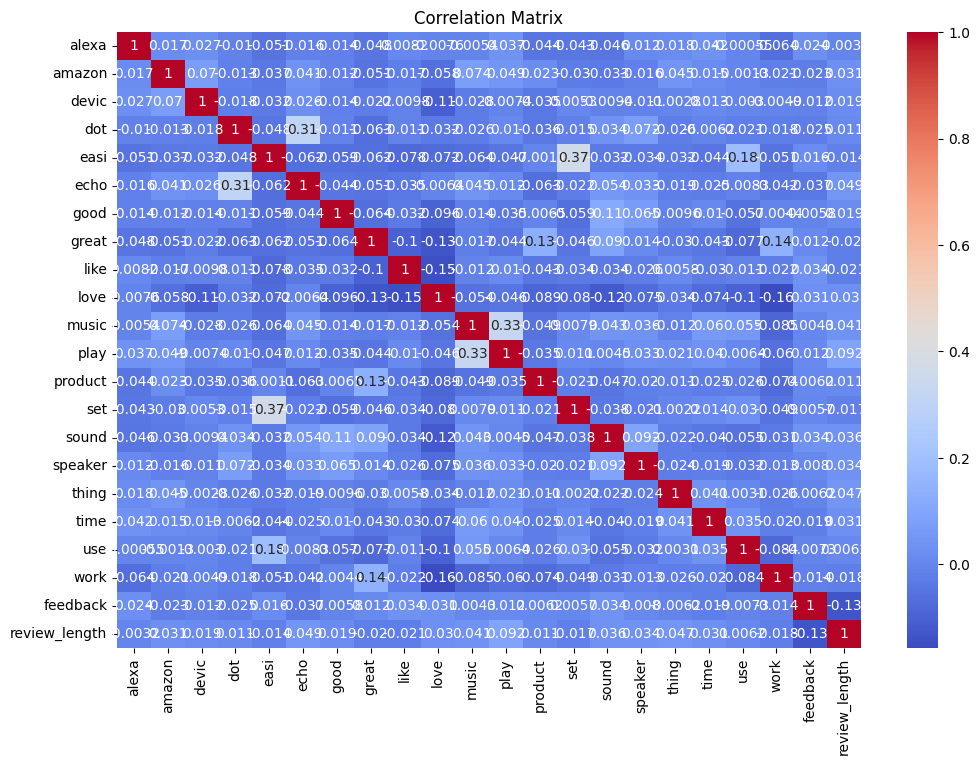

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## SVM task - Saran Prakash
## Accuracy = 86%
## roc auc curve = 97%
## run time speed = 99%

In [ ]:
# Label Encoding
df_encoded = df.copy()
le = LabelEncoder()
for column in ['date', 'variation']:
    df_encoded[column] = le.fit_transform(df_encoded[column])

In [ ]:
# Features and target
X = df_encoded[['processed_text', 'date']]
y = df_encoded['feedback']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)

In [ ]:
# SVM Model
vectorizer_svm = TfidfVectorizer()
X_train_vec = vectorizer_svm.fit_transform(X_train['processed_text'])
X_test_vec = vectorizer_svm.transform(X_test['processed_text'])

In [ ]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_vec, y_train)

SVC(probability=True)

In [ ]:
# Prediction
y_pred = svm_model.predict(X_test_vec)

In [ ]:
#Evaluation
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8571428571428571
Precision: 0.8524590163934426
Recall: 1.0
F1 Score: 0.9203539823008849
              precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.85      1.00      0.92        52

    accuracy                           0.86        63
   macro avg       0.93      0.59      0.61        63
weighted avg       0.88      0.86      0.81        63



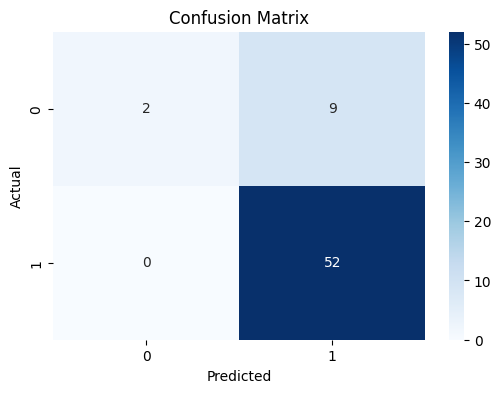

In [ ]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# ROC Curve and AUC
y_proba = svm_model.predict_proba(X_test_vec)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)

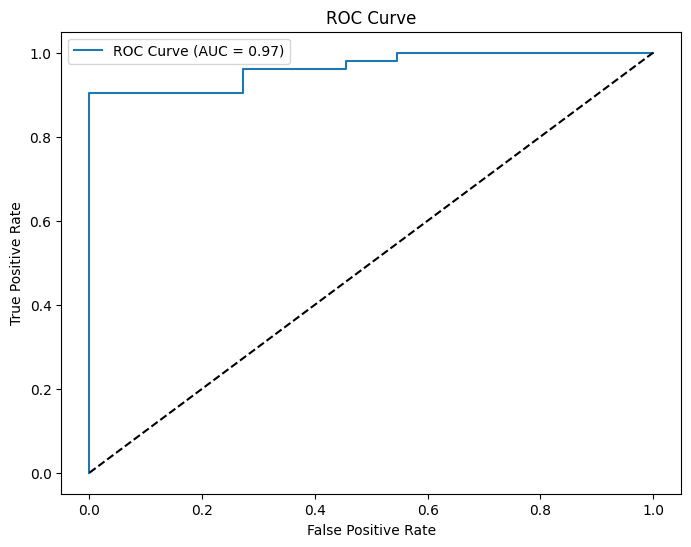

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
print(f"Final ROC AUC Score: {roc_auc:.4f}")

Final ROC AUC Score: 0.9650


ANN(Neural Network) Task - Manishankar

Accuracy = 93%

ROC-AUC score = 94%

run time speed = 95%

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8522 - loss: 0.5214 - val_accuracy: 0.9000 - val_loss: 0.2982
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9233 - loss: 0.2061 - val_accuracy: 0.9000 - val_loss: 0.2371
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9249 - loss: 0.1275 - val_accuracy: 0.9127 - val_loss: 0.2057
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9678 - loss: 0.0858 - val_accuracy: 0.9159 - val_loss: 0.2317
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9891 - loss: 0.0422 - val_accuracy: 0.9302 - val_loss: 0.2273
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9915 - loss: 0.0276 - val_accuracy: 0.9317 - val_loss: 0.2693

✅ Final Test Accuracy: 0.9317
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step



Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       0.79      0.43      0.56        63
           1       0.94      0.99      0.96       567

    accuracy                           0.93       630
   macro avg       0.87      0.71      0.76       630
weighted avg       0.93      0.93      0.92       630

Confusion Matrix:
 [[ 27  36]
 [  7 560]]

📈 Epoch-wise Training and Validation Accuracy:
Epoch 1: Train Acc = 0.9079, Val Acc = 0.9000
Epoch 2: Train Acc = 0.9234, Val Acc = 0.9000
Epoch 3: Train Acc = 0.9238, Val Acc = 0.9127
Epoch 4: Train Acc = 0.9746, Val Acc = 0.9159
Epoch 5: Train Acc = 0.9897, Val Acc = 0.9302
Epoch 6: Train Acc = 0.9921, Val Acc = 0.9317

✅ Neural network model and vectorizer saved successfully.


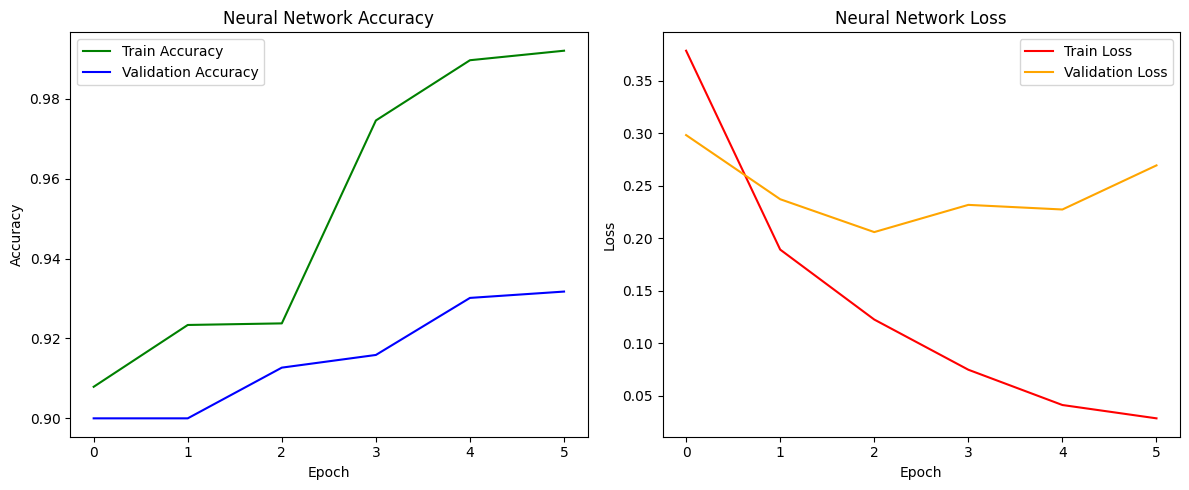

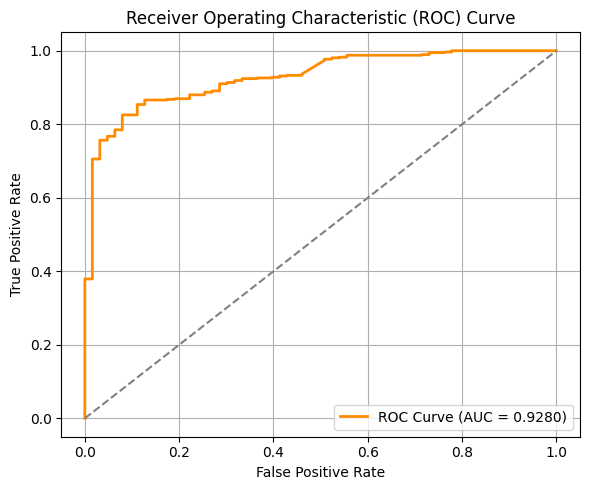

In [ ]:
import pandas as pd
import re
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import WordCloud

# Download stopwords
nltk.download('stopwords')

# Text cleaning function
def clean_text(text):
    stop_words = set(stopwords.words('english')) - {"not", "no"}
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Clean the reviews
df['cleaned_reviews'] = df['verified_reviews'].apply(clean_text)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['cleaned_reviews'])
y = df['feedback']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network Model (Keras)
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = nn_model.fit(
    X_train.toarray(), y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test.toarray(), y_test),
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
loss, test_accuracy = nn_model.evaluate(X_test.toarray(), y_test, verbose=0)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")

# Predict and evaluate
y_probs = nn_model.predict(X_test.toarray())
y_pred_nn = (y_probs > 0.5).astype("int32")
print("\nClassification Report (Neural Network):\n", classification_report(y_test, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))

# Print epoch-wise training & validation accuracy
print("\n📈 Epoch-wise Training and Validation Accuracy:")
for i, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), 1):
    print(f"Epoch {i}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

# Save NN model and vectorizer
nn_model.save("sentiment_nn_model.h5")
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
print("\n✅ Neural network model and vectorizer saved successfully.")

# Visualization: NN Training
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 🔵 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## LSTM task - Akshara
### Accuracy = 92%
### Roc auc curve = 87%
### run time speed = 85%

          variation  variation_encoded
0  Charcoal Fabric                   5
1  Charcoal Fabric                   5
2    Walnut Finish                  10
3  Charcoal Fabric                   5
4  Charcoal Fabric                   5
Epoch 1/5


<ipython-input-94-8e680ff5014f>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])  # Convert to datetime format
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.9124 - loss: 0.3390
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9403 - loss: 0.1808
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9764 - loss: 0.0783
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.9869 - loss: 0.0415
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9889 - loss: 0.0323
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy: 0.926984126984127
              precision    recall  f1-score   support

           0       0.71      0.46      0.56        63
           1       0.94      0.98      0.96       567

    accuracy                           0.93       630
   macro avg       0.82      0.72      0.76       630
weighted avg       0.92      0.93      0.92       630

Confusion Matrix:
 [[ 29  34]
 [ 12 555]]


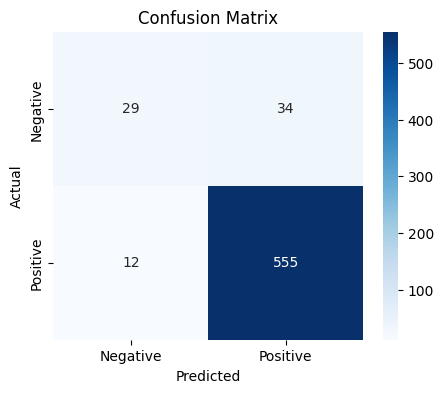

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
ROC-AUC Score: 0.85


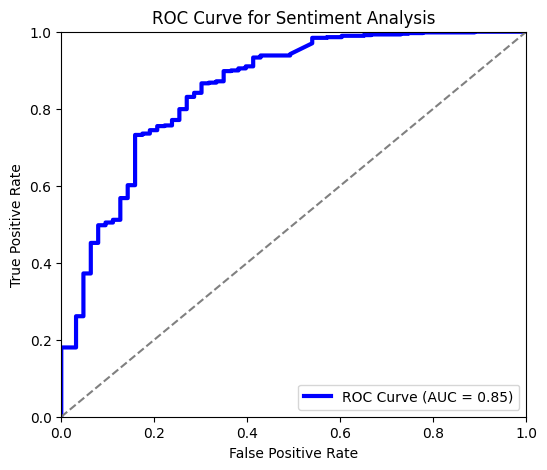


✅ LSTM model and tokenizer saved successfully.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding
le = LabelEncoder()
df['variation_encoded'] = le.fit_transform(df['variation'])

print(df[['variation', 'variation_encoded']].head())

df['date'] = pd.to_datetime(df['date'])  # Convert to datetime format
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['rating_scaled'] = scaler.fit_transform(df[['rating']])

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# converting text into numerical sequences using Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['processed_text'])
sequences = tokenizer.texts_to_sequences(df['processed_text'])

# Padding Sequences ensures uniform input length (100) for models
X = pad_sequences(sequences, maxlen=100)
y = df['feedback'].values

# Split the data before model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100), #Converts words into vector representations (128 dimensions).
    LSTM(64, return_sequences=False), #Captures sequential dependencies with 64 units.
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=5, batch_size=16)


from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Print numerical matrix
print("Confusion Matrix:\n", cm)

# Visualize confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


from sklearn.metrics import roc_auc_score

# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=3, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='grey', linestyle='--')  # Reference diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sentiment Analysis')
plt.legend(loc='lower right')
plt.show()

# Save LSTM model and tokenizer
model.save("sentiment_lstm_model.keras")  # Saves the LSTM model
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)  # Saves the tokenizer
print("\n✅ LSTM model and tokenizer saved successfully.")

*NAIVE* BAYES -- KIRANVEL R

ACCCURACY-- 91%

ROC_AUC score = 86%

Accuracy: 0.9015873015873016

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.22      0.31        63
           1       0.92      0.98      0.95       567

    accuracy                           0.90       630
   macro avg       0.72      0.60      0.63       630
weighted avg       0.88      0.90      0.88       630



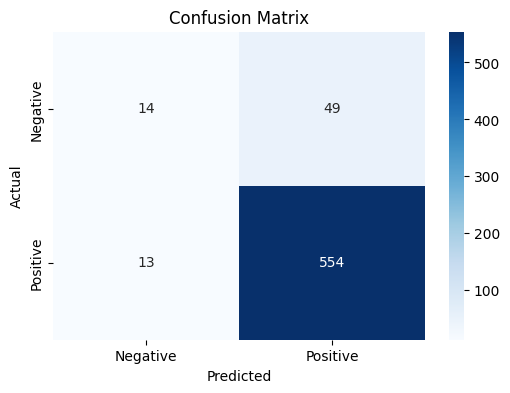

ROC AUC Score: 0.86


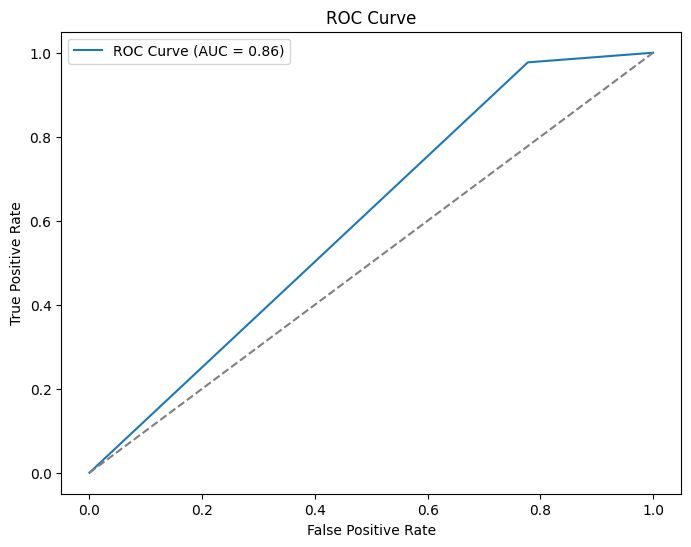


✅ Naive bayes model saved successfully.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Vectorize text
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])

# Target variable
y = df['feedback']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred = nb_model.predict(X_test)

#  Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities
y_prob = nb_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

with open('nb_model.pkl', 'wb') as file:
    pickle.dump(nb_model, file)
print("\n✅ Naive bayes model saved successfully.")

RANDOM FOREST- SUSHINTH

ROC-AUC score = 90%

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Extract relevant columns
X = df["processed_text"]
y = df["feedback"]

# Convert text to numerical vectors
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

# Initialize model
model = RandomForestClassifier(n_estimators=100, random_state=42) #100 decision trees and ensures consistent results

# Train model
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report

# Predict sentiments
y_pred = model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print(report)


Model Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.95      0.29      0.44        63
           1       0.93      1.00      0.96       567

    accuracy                           0.93       630
   macro avg       0.94      0.64      0.70       630
weighted avg       0.93      0.93      0.91       630



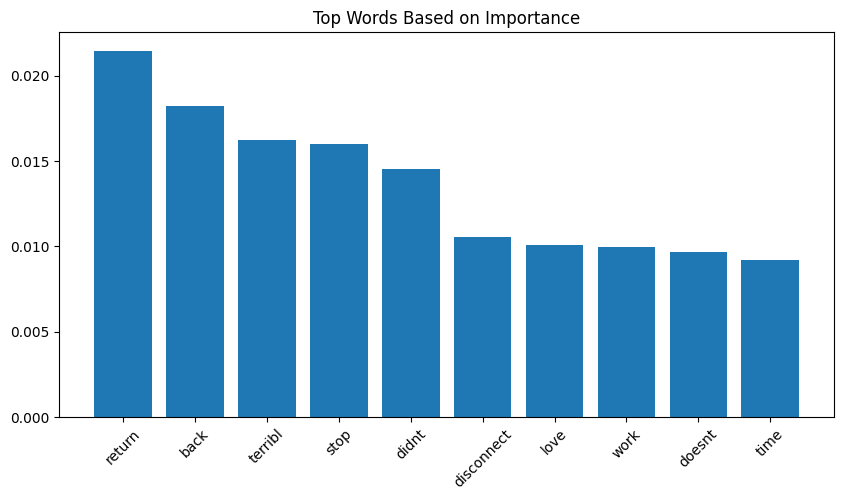

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top features
plt.figure(figsize=(10,5))
plt.title("Top Words Based on Importance")
plt.bar(range(10), importances[indices[:10]])
plt.xticks(range(10), [vectorizer.get_feature_names_out()[i] for i in indices[:10]], rotation=45)
plt.show()


In [ ]:
# Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")

ROC-AUC Score: 0.90


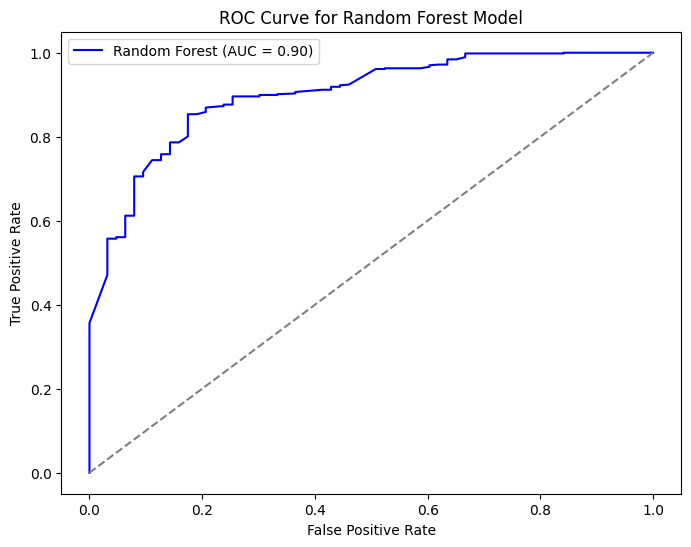

✅ Random Forest model saved successfully.


In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest Model")
plt.legend()
plt.show()

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("✅ Random Forest model saved successfully.")

LOGISTIC REGRESSION - SMRITHI

ROC AUC SCORE = 94%

Accuracy: 0.8984126984126984
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.90      1.00      0.95       567

    accuracy                           0.90       630
   macro avg       0.45      0.50      0.47       630
weighted avg       0.81      0.90      0.85       630

Confusion Matrix:
 [[  0  63]
 [  1 566]]
✅ Model and vectorizer saved successfully.


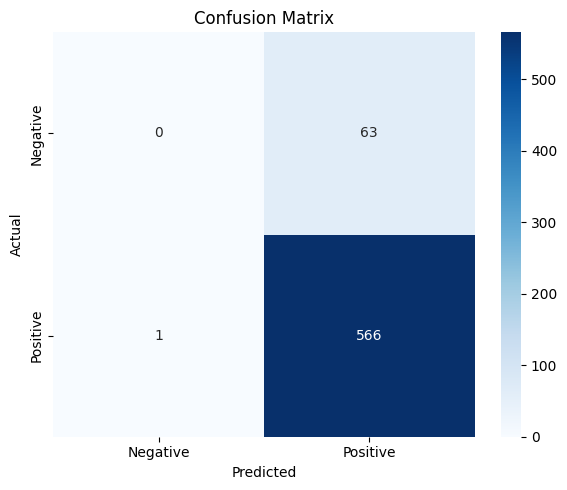

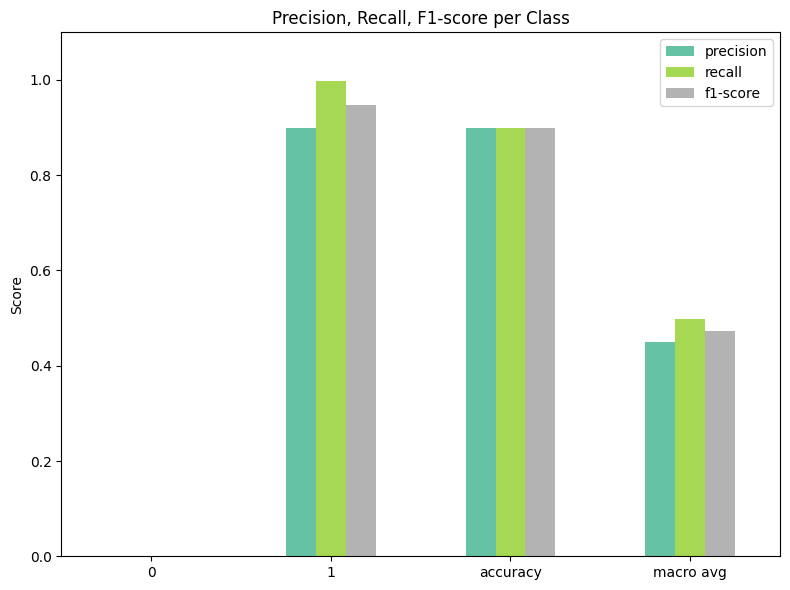

<ipython-input-100-f620b0a6400d>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_n, palette='coolwarm')


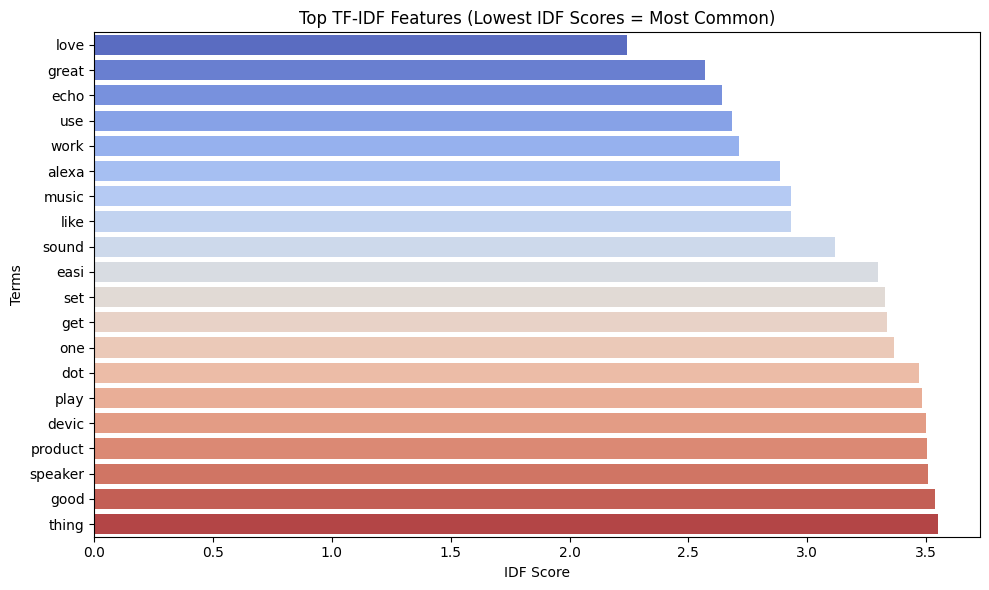

In [ ]:
from sklearn.linear_model import LogisticRegression
# ----------------- TF-IDF VECTORIZATION ------------------
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['processed_text'])
y = df['feedback']

# ----------------- TRAIN-TEST SPLIT ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- MODEL TRAINING ------------------
model = LogisticRegression()
model.fit(X_train, y_train)

# ----------------- EVALUATION ------------------
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ----------------- SAVE MODEL AND VECTORIZER ------------------
with open("sentiment_model_logreg.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("✅ Model and vectorizer saved successfully.")

# ----------------- VISUALIZATION ------------------

# Plot 1: Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot 2: Classification Report as Bar Chart
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-1, :-1]
report_df.plot(kind='bar', figsize=(8,6), colormap='Set2')
plt.title("Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Plot 3: Most Frequent TF-IDF Features
def plot_top_tfidf_features(vectorizer, n=20):
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(vectorizer.idf_)

    top_n = feature_array[tfidf_sorting][:n]
    top_scores = vectorizer.idf_[tfidf_sorting][:n]

    plt.figure(figsize=(10,6))
    sns.barplot(x=top_scores, y=top_n, palette='coolwarm')
    plt.title("Top TF-IDF Features (Lowest IDF Scores = Most Common)")
    plt.xlabel("IDF Score")
    plt.ylabel("Terms")
    plt.tight_layout()
    plt.show()

plot_top_tfidf_features(tfidf, n=20)


ROC AUC Score: 0.94


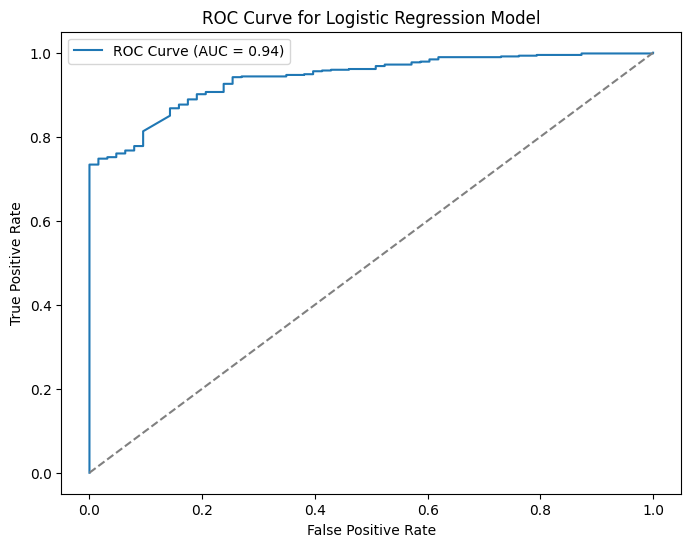

In [ ]:
# --- ROC AUC Score ---
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression Model")
plt.legend()
plt.show()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Naive Bayes'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'SVM'),
  Text(3, 0, 'Logistic Regression'),
  Text(4, 0, 'ANN'),
  Text(5, 0, 'LSTM')])

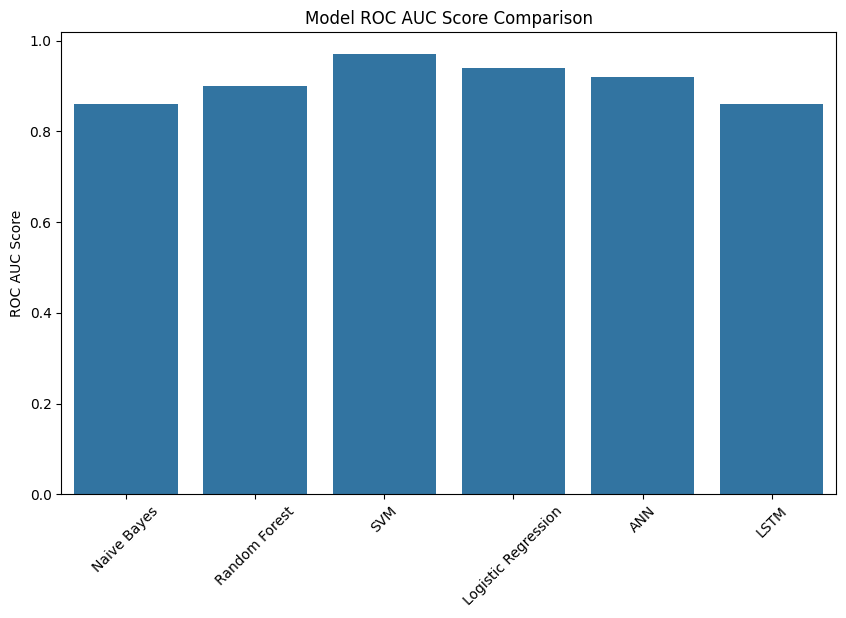

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ROC AUC results (replace with actual values from your evaluation)
roc_auc_results = {
    "Naive Bayes": 0.86,
    "Random Forest": 0.90,
    "SVM": 0.97,
    "Logistic Regression": 0.94,
    "ANN": 0.92,
    "LSTM": 0.86
}

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=list(roc_auc_results.keys()), y=list(roc_auc_results.values()))
plt.title("Model ROC AUC Score Comparison")
plt.ylabel("ROC AUC Score")
plt.xticks(rotation=45)
